# Random Forest Modelling Notebook for DEFRA

- This notebook for Random Forest training using 2D flattened data.
- Inputs will be taken from: `data/defra/ml_prep` folder.
- Following the same structure as LAQN RF training for direct comparison.
- Using Géron's *Hands-On Machine Learning with Scikit-Learn, Keras and TensorFlow* 3rd edition.

---

## What this notebook does

1. Load prepared data from ml_prep output.
2. Understand the X and y structure (following Géron Chapter 2).
3. Train a baseline Random Forest model.
4. Evaluate using RMSE, MAE, R² (Géron Chapter 2 evaluation approach).
5. Fine-tune hyperparameters with GridSearchCV (Géron Chapter 2).
6. Analyse feature importance.
7. Save the trained model.

---

## Why Random Forest?

From Géron (2023, Chapter 7), Random Forest is an ensemble of Decision Trees trained on different random subsets of the training data. Each tree votes on the prediction, and the final output is the average (for regression) or majority vote (for classification).

Key advantages for air quality prediction:
- Handles nonlinear relationships without feature scaling.
- Provides feature importance for interpretability.
- Robust against overfitting when properly tuned.
- Works well with tabular data like our flattened time series.

---

## DEFRA vs LAQN comparison context

| Metric | LAQN | DEFRA |
| --- | --- | --- |
| Training samples | 9,946 | 11,138 |
| Validation samples | 2,131 | 2,387 |
| Test samples | 2,132 | 2,387 |
| Features (flattened) | 468 | 288 |
| Original features | 39 | 24 |
| Target station | EN5_NO2 | London_Haringey_Priory_Park_South_NO2 |
| Distance between targets | ~3.3 km | - |

This comparison tests whether DEFRA's higher completeness (91.2% vs 87.1%) compensates for fewer stations.

In [1]:
# mandatory libraries for random forest training

import numpy as np
import pandas as pd
import joblib
import os
from pathlib import Path
import time

# scikit-learn for random forest and evaluation
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import cross_val_score

# before grid search, I decided to use kfold n_splits=5
from sklearn.model_selection import KFold

# modules for evaluation metrics - scikit-learn
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# gridsearch for hyperparameter tuning
from sklearn.model_selection import GridSearchCV

# visualisation
import matplotlib.pyplot as plt

### File paths

Loading from the ml_prep output folder where all prepared arrays are saved.

**CHANGE FROM LAQN:** Path changed from `data/laqn/ml_prep` to `data/defra/ml_prep`

In [2]:
# Paths setup matching ml_prep output 
base_dir = Path.cwd().parent.parent / "data" / "defra"
ml_prep_dir = base_dir / "ml_prep"

# Output folder for this notebook
rf_output_dir = base_dir / "rf_model"
rf_output_dir.mkdir(parents=True, exist_ok=True)

print(f"Loading data from: {ml_prep_dir}")
print(f"Saving results to: {rf_output_dir}")

Loading data from: /Users/burdzhuchaglayan/Desktop/data science projects/air-pollution-levels/data/defra/ml_prep
Saving results to: /Users/burdzhuchaglayan/Desktop/data science projects/air-pollution-levels/data/defra/rf_model


## 1) Load prepared data

The ml_prep notebook created:
- `X_train_rf.npy`: Flattened training features (11,138 samples × 288 features)
- `X_val_rf.npy`: Flattened validation features (2,387 samples × 288 features)
- `X_test_rf.npy`: Flattened test features (2,387 samples × 288 features)
- `y_train.npy`, `y_val.npy`, `y_test.npy`: Target values
- `rf_feature_names.joblib`: Feature names for interpretability
- `scaler.joblib`: MinMaxScaler to reverse normalisation

The flattening was necessary because Random Forest expects 2D input (samples, features), but the original sequences were 3D (samples, timesteps, features).

### DEFRA vs LAQN data shapes:

| Dataset | LAQN | DEFRA |
| --- | --- | --- |
| X_train_rf | (9946, 468) | (11138, 288) |
| X_val_rf | (2131, 468) | (2387, 288) |
| X_test_rf | (2132, 468) | (2387, 288) |
| y_train | (9946, 39) | (11138, 24) |

DEFRA has ~12% more samples but fewer features (24 vs 39 original, 288 vs 468 flattened).

In [3]:
# load all prepared data
print("Loading data")

X_train = np.load(ml_prep_dir / "X_train_rf.npy")
X_val = np.load(ml_prep_dir / "X_val_rf.npy")
X_test = np.load(ml_prep_dir / "X_test_rf.npy")

y_train = np.load(ml_prep_dir / "y_train.npy")
y_val = np.load(ml_prep_dir / "y_val.npy")
y_test = np.load(ml_prep_dir / "y_test.npy")

rf_feature_names = joblib.load(ml_prep_dir / "rf_feature_names.joblib")
feature_names = joblib.load(ml_prep_dir / "feature_names.joblib")
scaler = joblib.load(ml_prep_dir / "scaler.joblib")

Loading data


In [4]:
# check loaded data shapes

print(f"X_train shape: {X_train.shape}")
print(f"X_val shape: {X_val.shape}")
print(f"X_test shape: {X_test.shape}")
print(f"y_train shape: {y_train.shape}")
print(f"y_val shape: {y_val.shape}")
print(f"y_test shape: {y_test.shape}")
print(f"Number of RF features: {len(rf_feature_names)}")
print(f"Number of target features: {len(feature_names)}")

X_train shape: (11138, 288)
X_val shape: (2387, 288)
X_test shape: (2387, 288)
y_train shape: (11138, 24)
y_val shape: (2387, 24)
y_test shape: (2387, 24)
Number of RF features: 288
Number of target features: 24


X_train shape: (11138, 288)
X_val shape: (2387, 288)
X_test shape: (2387, 288)
y_train shape: (11138, 24)
y_val shape: (2387, 24)
y_test shape: (2387, 24)
Number of RF features: 288
Number of target features: 24

## 2) Select target pollutant

The y array has 24 outputs (one for each feature). For better evaluation, I will train a single-output model first.

### Why single-output?

Starting with one target keeps things simple:
- Easier to interpret evaluation metrics (RMSE, R² for one pollutant).
- Easier to understand feature importance (what predicts NO2 specifically).
- Can train separate models for PM10 and O3 later and compare.

### Which target to select?

From DEFRA ml_prep, the target station is **London_Haringey_Priory_Park_South_NO2**:
- Located ~3.3 km from LAQN's EN5 station
- 95.1% data coverage
- Enables direct comparison with LAQN RF results

In [5]:
# list targets
print("Available targets:")
for i, name in enumerate(feature_names):
    print(f"  {i:2d}: {name}")

Available targets:
   0: London_Hillingdon_O3
   1: London_Harlington_PM10
   2: London_Hillingdon_NO2
   3: London_Westminster_NO2
   4: London_Honor_Oak_Park_PM10
   5: London_N._Kensington_NO2
   6: Camden_Kerbside_NO2
   7: London_Hillingdon_PM10
   8: Southwark_A2_Old_Kent_Road_NO2
   9: Borehamwood_Meadow_Park_NO2
  10: London_Bloomsbury_NO2
  11: London_Harlington_NO2
  12: Borehamwood_Meadow_Park_PM10
  13: London_Bloomsbury_O3
  14: London_N._Kensington_O3
  15: London_Haringey_Priory_Park_South_NO2
  16: London_Bexley_NO2
  17: London_Westminster_O3
  18: London_Bloomsbury_PM10
  19: London_Marylebone_Road_NO2
  20: hour
  21: day_of_week
  22: month
  23: is_weekend


Available targets:
   0: London_Hillingdon_O3
   1: London_Harlington_PM10
   2: London_Hillingdon_NO2
   3: London_Westminster_NO2
   4: London_Honor_Oak_Park_PM10
   5: London_N._Kensington_NO2
   6: Camden_Kerbside_NO2
   7: London_Hillingdon_PM10
   8: Southwark_A2_Old_Kent_Road_NO2
   9: Borehamwood_Meadow_Park_NO2
  10: London_Bloomsbury_NO2
  11: London_Harlington_NO2
  12: Borehamwood_Meadow_Park_PM10
  13: London_Bloomsbury_O3
  14: London_N._Kensington_O3
  15: London_Haringey_Priory_Park_South_NO2
  16: London_Bexley_NO2
  17: London_Westminster_O3
  18: London_Bloomsbury_PM10
  19: London_Marylebone_Road_NO2
  20: hour
  21: day_of_week
  22: month
  23: is_weekend

In [6]:
# find the target station index
# From ml_prep: London_Haringey_Priory_Park_South_NO2 is our target
target_name = "London_Haringey_Priory_Park_South_NO2"

# find index of target in feature_names
try:
    target_idx = feature_names.index(target_name)
except ValueError:
    # if exact name not found, search for partial match
    for i, name in enumerate(feature_names):
        if 'Haringey' in name and 'NO2' in name:
            target_idx = i
            target_name = name
            break

y_train_single = y_train[:, target_idx]
y_val_single = y_val[:, target_idx]
y_test_single = y_test[:, target_idx]

print(f"Target: {target_name}")
print(f"Target index: {target_idx}")
print(f"y_train_single: {y_train_single.shape}")
print(f"Range: [{y_train_single.min():.4f}, {y_train_single.max():.4f}]")

Target: London_Haringey_Priory_Park_South_NO2
Target index: 15
y_train_single: (11138,)
Range: [0.0000, 1.0000]


Target: London_Haringey_Priory_Park_South_NO2
Target index: 15
y_train_single: (11138,)
Range: [0.0000, 1.0000]

## 3) Train baseline model (Géron Chapter 7)

From Géron (2023, Chapter 7 - Ensemble Learning and Random Forests):

> "A random forest is an ensemble of decision trees, generally trained via the bagging method (or sometimes pasting), typically with `max_samples` set to the size of the training set. Instead of building a `BaggingClassifier` and passing it a `DecisionTreeClassifier`, you can use the `RandomForestClassifier` class, which is more convenient and optimized for decision trees (similarly, there is a `RandomForestRegressor` class for regression tasks)."

Since I am predicting continuous pollution values (regression), I use `RandomForestRegressor`.

### Key parameters:

| Parameter | Default | What it does |
| --- | --- | --- |
| n_estimators | 100 | Number of trees in the forest |
| max_leaf_nodes | None | Maximum leaf nodes per tree |
| n_jobs | -1 | CPU cores to use (-1 = all available) |
| random_state | 42 | Seed for reproducibility |

Géron's example uses `n_estimators=500` and `max_leaf_nodes=16`, but I start with defaults to establish a baseline before tuning.

In [7]:
# train baseline Random Forest
# Using RandomForestRegressor for regression task predicting continuous values following Géron's structure from Chapter 7

print("Training baseline Random Forest")
print("-" * 40)

start = time.time()

# baseline with default parameters
rf_baseline = RandomForestRegressor(
    n_estimators=100,      # default, Géron's example uses 500
    random_state=42,       # for reproducibility
    n_jobs=-1              # use all CPU cores
)

rf_baseline.fit(X_train, y_train_single)

baseline_time = time.time() - start

print(f"\nTraining complete in {baseline_time:.2f} seconds")
print(f"Number of trees: {rf_baseline.n_estimators}")
print(f"Max leaf nodes: {rf_baseline.max_leaf_nodes}")
print(f"Max depth: {rf_baseline.max_depth}")

Training baseline Random Forest
----------------------------------------

Training complete in 33.32 seconds
Number of trees: 100
Max leaf nodes: None
Max depth: None


    Training baseline Random Forest
    ----------------------------------------

    Training complete in 33.32 seconds
    Number of trees: 100
    Max leaf nodes: None
    Max depth: None

## 4) Evaluate baseline model

To evaluate the baseline model, I use three metrics from scikit-learn's `sklearn.metrics` module.

### RMSE (Root Mean Square Error)

$$RMSE = \sqrt{\frac{1}{n}\sum_{i=1}^{n}(y_i - \hat{y}_i)^2}$$

Penalises large errors more heavily. Lower is better.

```python
from sklearn.metrics import mean_squared_error

rmse = np.sqrt(mean_squared_error(y_true, y_pred))
```

### MAE (Mean Absolute Error)

$$MAE = \frac{1}{n}\sum_{i=1}^{n}|y_i - \hat{y}_i|$$

Average absolute difference between actual and predicted. More interpretable than RMSE. Lower is better.

### R² (Coefficient of Determination)

$$R^2 = 1 - \frac{\sum(y_i - \hat{y}_i)^2}{\sum(y_i - \bar{y})^2}$$

Proportion of variance explained by the model. Range 0 to 1, higher is better.

In [8]:
def evaluate(model, X, y_true, name):
    """
    Evaluate model using RMSE, MAE, and R².
    
    Params:
    model : trained sklearn model
    X : feature matrix (n_samples, n_features)
    y_true : actual values (n_samples,)
    name : string for display
    
    Returns: dict with rmse, mae, r2, and y_pred
    """
    y_pred = model.predict(X)
    
    # RMSE using np.sqrt
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    
    # MAE avg absolute difference
    mae = mean_absolute_error(y_true, y_pred)
    
    # R^2 proportion of variance explained
    r2 = r2_score(y_true, y_pred)
    
    print(f"{name}:")
    print(f"  RMSE = {rmse:.6f}")
    print(f"  MAE  = {mae:.6f}")
    print(f"  R^2  = {r2:.6f}")
    
    return {'rmse': rmse, 'mae': mae, 'r2': r2, 'y_pred': y_pred}

In [9]:
# Evaluate baseline on three sets
print("Baseline Model Evaluation")
print("=" * 40)

base_train = evaluate(rf_baseline, X_train, y_train_single, "Training")
print()
base_val = evaluate(rf_baseline, X_val, y_val_single, "Validation")
print()
base_test = evaluate(rf_baseline, X_test, y_test_single, "Test")

Baseline Model Evaluation
Training:
  RMSE = 0.016983
  MAE  = 0.011019
  R^2  = 0.984685

Validation:
  RMSE = 0.042742
  MAE  = 0.027620
  R^2  = 0.865686

Test:
  RMSE = 0.033585
  MAE  = 0.022963
  R^2  = 0.851746


    Baseline Model Evaluation
    ========================================
    Training:
    RMSE = 0.016983
    MAE  = 0.011019
    R^2  = 0.984685

    Validation:
    RMSE = 0.042742
    MAE  = 0.027620
    R^2  = 0.865686

    Test:
    RMSE = 0.033585
    MAE  = 0.022963
    R^2  = 0.851746

The gap between training R² (0.985) and validation R² (0.866) is **0.119** which shows mild overfitting. Similar to LAQN (0.118 gap), the model memorised training data rather than learning general patterns. However, DEFRA's validation R² (0.866) is already higher than LAQN's (0.861), suggesting better generalisation despite similar overfitting levels.

### Checking for overfitting

The training R² is higher than validation R², indicating some overfitting. This happens when the model memorises training data instead of learning general patterns.

Signs of overfitting:
- Training R² close to 1.0 (0.985), validation R² lower (0.866).
- Gap of 0.119 between training and validation R².

**DEFRA vs LAQN overfitting comparison:**

| Metric | LAQN | DEFRA |
|--------|------|-------|
| Training R² | 0.979 | 0.985 |
| Validation R² | 0.861 | 0.866 |
| Gap | 0.118 | 0.119 |

Both datasets show similar overfitting levels (~0.12 gap). However, DEFRA starts from a higher baseline, so even with overfitting, it generalises better. I'll tune hyperparameters to reduce overfitting further.

In [10]:
# overfitting check
r2_gap = base_train['r2'] - base_val['r2']
print("Overfitting Check")
print("=" * 40)
print(f"Training R^2:   {base_train['r2']:.4f}")
print(f"Validation R^2: {base_val['r2']:.4f}")
print(f"Gap:            {r2_gap:.4f}")

if r2_gap > 0.15:
    print(f"\nModel overfits significantly.")
elif r2_gap > 0.05:
    print("\nMild overfitting = tuning may help.")
else:
    print("\nNo significant overfitting.")

Overfitting Check
Training R^2:   0.9847
Validation R^2: 0.8657
Gap:            0.1190

Mild overfitting = tuning may help.


    Overfitting Check
    ========================================
    Training R^2:   0.9847
    Validation R^2: 0.8657
    Gap:            0.1190

    Mild overfitting = tuning may help.

## 5) Cross-validation 

### What is K-fold cross-validation?

From scikit-learn documentation:
> "K-Fold cross-validator provides train/test indices to split data in train/test sets. Split dataset into k consecutive folds (without shuffling by default). Each fold is then used once as a validation while the k - 1 remaining folds form the training set."

### sklearn.model_selection.KFold

```python
class sklearn.model_selection.KFold(n_splits=5, shuffle=False, random_state=None)
```

**Parameters:**
- `n_splits`: int, default=5. Number of folds. Must be at least 2.
- `shuffle`: bool, default=False. Whether to shuffle the data before splitting.
- `random_state`: int or None. Controls randomness when shuffle is True.

In [11]:
kf = KFold(n_splits=5)
cv_rmse_scores = []

print("Running 5-fold Cross-Validation:")
print("-" * 40)

for i, (train_idx, val_idx) in enumerate(kf.split(X_train)):
    # split data
    X_fold_train = X_train[train_idx]
    X_fold_val = X_train[val_idx]
    y_fold_train = y_train_single[train_idx]
    y_fold_val = y_train_single[val_idx]
    
    # train and evaluate
    rf_baseline.fit(X_fold_train, y_fold_train)
    y_pred = rf_baseline.predict(X_fold_val)
    rmse = np.sqrt(mean_squared_error(y_fold_val, y_pred))
    cv_rmse_scores.append(rmse)
    print(f"Fold {i+1}: RMSE = {rmse:.6f}")

print(f"\nCV RMSE: {np.mean(cv_rmse_scores):.6f} +/- {np.std(cv_rmse_scores):.6f}")

Running 5-fold Cross-Validation:
----------------------------------------
Fold 1: RMSE = 0.050789
Fold 2: RMSE = 0.050265
Fold 3: RMSE = 0.049500
Fold 4: RMSE = 0.037068
Fold 5: RMSE = 0.045720

CV RMSE: 0.046668 +/- 0.005119


    Running 5-fold Cross-Validation:
    ----------------------------------------
    Fold 1: RMSE = 0.050789
    Fold 2: RMSE = 0.050265
    Fold 3: RMSE = 0.049500
    Fold 4: RMSE = 0.037068
    Fold 5: RMSE = 0.045720

    CV RMSE: 0.046668 +/- 0.005119

## 5-Fold Cross-Validation Results

### DEFRA Results:
| Fold | RMSE |
|------|------|
| Fold 1 | 0.050789 |
| Fold 2 | 0.050265 |
| Fold 3 | 0.049500 |
| Fold 4 | 0.037068 |
| Fold 5 | 0.045720 |
| **CV RMSE** | **0.046668 ± 0.005119** |

### DEFRA vs LAQN Cross-Validation Comparison:

| Metric | LAQN | DEFRA | Difference |
|--------|------|-------|------------|
| CV RMSE (mean) | 0.054215 | 0.046668 | -13.9% ✓ |
| CV RMSE (std) | 0.004412 | 0.005119 | +16.0% |
| Best fold | 0.049685 | 0.037068 | -25.4% ✓ |
| Worst fold | 0.062451 | 0.050789 | -18.7% ✓ |
| Range | 0.012766 | 0.013721 | +7.5% |

### Key observations:

**1. DEFRA has lower mean CV RMSE (0.047 vs 0.054)**

DEFRA predictions are ~14% more accurate on average across all folds. This confirms the baseline findings - higher data quality leads to better predictions.

**2. DEFRA has slightly higher variance (±0.005 vs ±0.004)**

DEFRA's fold scores vary more, particularly Fold 4 (0.037) which is unusually good. This suggests some time periods in DEFRA data are easier to predict than others.

**3. Both datasets show consistent performance**

Neither shows extreme variation between folds, indicating stable model behaviour across different data subsets.

**Interpretation:**

The cross-validation confirms DEFRA's superior performance is genuine, not a lucky train/test split. The 14% lower CV RMSE demonstrates that DEFRA's higher data completeness (91.2% vs 87.1%) translates to measurably better predictions.

## 6) Hyperparameter tuning with GridSearchCV

From Géron (2023, Chapter 2):

> "GridSearchCV uses cross-validation to evaluate all the possible combinations of hyperparameter values you want to test."

### Parameter grid

Using the same grid as LAQN for fair comparison:

| Parameter | Values to test | Purpose |
| --- | --- | --- |
| n_estimators | [100, 200] | Number of trees |
| max_depth | [10, 20, None] | Tree depth limit |
| min_samples_split | [2, 5] | Minimum samples to split |
| min_samples_leaf | [1, 2] | Minimum samples in leaf |

Total combinations: 2 × 3 × 2 × 2 = 24

In [12]:
# define parameter grid - same as LAQN for fair comparison
param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [10, 20, None],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2]
}

# calculate total combinations
total_combinations = 1
for values in param_grid.values():
    total_combinations *= len(values)

print(f"Parameter grid: {total_combinations} combinations")
print(f"With 3-fold CV: {total_combinations * 3} total fits")

Parameter grid: 24 combinations
With 3-fold CV: 72 total fits


    Parameter grid: 24 combinations
    With 3-fold CV: 72 total fits

In [13]:
# run GridSearchCV 
print("Running GridSearchCV")
print("-" * 40)

start_time = time.time()

rf_grid = RandomForestRegressor(random_state=42, n_jobs=-1)

grid_search = GridSearchCV(
    estimator=rf_grid,
    param_grid=param_grid,
    cv=3,           # 3-fold cross-validation
    scoring='neg_mean_squared_error',
    verbose=2,      # display computation time and score
    n_jobs=-1       # use all processors
)

grid_search.fit(X_train, y_train_single)

tuning_time = time.time() - start_time
print(f"\nGridSearchCV complete in {tuning_time:.2f} seconds ({tuning_time/60:.2f} minutes)")

Running GridSearchCV
----------------------------------------
Fitting 3 folds for each of 24 candidates, totalling 72 fits
[CV] END max_depth=10, min_samples_leaf=1, min_samples_split=5, n_estimators=100; total time= 1.6min
[CV] END max_depth=10, min_samples_leaf=1, min_samples_split=5, n_estimators=100; total time= 1.6min
[CV] END max_depth=10, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time= 1.7min
[CV] END max_depth=10, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time= 1.7min
[CV] END max_depth=10, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time= 1.7min
[CV] END max_depth=10, min_samples_leaf=1, min_samples_split=2, n_estimators=200; total time= 3.2min
[CV] END max_depth=10, min_samples_leaf=1, min_samples_split=5, n_estimators=100; total time= 1.6min
[CV] END max_depth=10, min_samples_leaf=2, min_samples_split=2, n_estimators=100; total time= 1.6min
[CV] END max_depth=10, min_samples_leaf=1, min_samples_split=2, n_est

    Running GridSearchCV
    ----------------------------------------
    Fitting 3 folds for each of 24 candidates, totalling 72 fits
    [CV] END max_depth=10, min_samples_leaf=1, min_samples_split=5, n_estimators=100; total time= 1.6min
    [CV] END max_depth=10, min_samples_leaf=1, min_samples_split=5, n_estimators=100; total time= 1.6min
    [CV] END max_depth=10, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time= 1.7min
    [CV] END max_depth=10, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time= 1.7min
    [CV] END max_depth=10, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time= 1.7min
    [CV] END max_depth=10, min_samples_leaf=1, min_samples_split=2, n_estimators=200; total time= 3.2min
    [CV] END max_depth=10, min_samples_leaf=1, min_samples_split=5, n_estimators=100; total time= 1.6min
    [CV] END max_depth=10, min_samples_leaf=2, min_samples_split=2, n_estimators=100; total time= 1.6min
    [CV] END max_depth=10, min_samples_leaf=1, min_samples_split=2, n_estimators=200; total time= 3.3min
    [CV] END max_depth=10, min_samples_leaf=1, min_samples_split=2, n_estimators=200; total time= 3.4min
    [CV] END max_depth=10, min_samples_leaf=1, min_samples_split=5, n_estimators=200; total time= 3.1min
    [CV] END max_depth=10, min_samples_leaf=1, min_samples_split=5, n_estimators=200; total time= 3.1min
    [CV] END max_depth=10, min_samples_leaf=2, min_samples_split=2, n_estimators=100; total time= 1.6min
    [CV] END max_depth=10, min_samples_leaf=1, min_samples_split=5, n_estimators=200; total time= 3.2min
    [CV] END max_depth=10, min_samples_leaf=2, min_samples_split=2, n_estimators=100; total time= 1.6min
    [CV] END max_depth=10, min_samples_leaf=2, min_samples_split=5, n_estimators=100; total time= 1.5min
    [CV] END max_depth=10, min_samples_leaf=2, min_samples_split=2, n_estimators=200; total time= 3.0min
    [CV] END max_depth=10, min_samples_leaf=2, min_samples_split=5, n_estimators=100; total time= 1.6min
    [CV] END max_depth=10, min_samples_leaf=2, min_samples_split=5, n_estimators=100; total time= 1.6min
    [CV] END max_depth=10, min_samples_leaf=2, min_samples_split=2, n_estimators=200; total time= 3.2min
    [CV] END max_depth=10, min_samples_leaf=2, min_samples_split=2, n_estimators=200; total time= 3.2min
    [CV] END max_depth=10, min_samples_leaf=2, min_samples_split=5, n_estimators=200; total time= 3.1min
    [CV] END max_depth=10, min_samples_leaf=2, min_samples_split=5, n_estimators=200; total time= 3.3min
    [CV] END max_depth=20, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time= 2.5min
    [CV] END max_depth=20, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time= 2.5min
    [CV] END max_depth=20, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time= 2.6min
    [CV] END max_depth=10, min_samples_leaf=2, min_samples_split=5, n_estimators=200; total time= 3.2min
    [CV] END max_depth=20, min_samples_leaf=1, min_samples_split=5, n_estimators=100; total time= 2.5min
    [CV] END max_depth=20, min_samples_leaf=1, min_samples_split=5, n_estimators=100; total time= 2.4min
    [CV] END max_depth=20, min_samples_leaf=1, min_samples_split=5, n_estimators=100; total time= 2.4min
    [CV] END max_depth=20, min_samples_leaf=1, min_samples_split=2, n_estimators=200; total time= 5.2min
    [CV] END max_depth=20, min_samples_leaf=1, min_samples_split=2, n_estimators=200; total time= 5.4min
    [CV] END max_depth=20, min_samples_leaf=1, min_samples_split=2, n_estimators=200; total time= 4.9min
    [CV] END max_depth=20, min_samples_leaf=1, min_samples_split=5, n_estimators=200; total time= 4.5min
    [CV] END max_depth=20, min_samples_leaf=2, min_samples_split=2, n_estimators=100; total time= 2.2min
    [CV] END max_depth=20, min_samples_leaf=2, min_samples_split=2, n_estimators=100; total time= 2.2min
    [CV] END max_depth=20, min_samples_leaf=2, min_samples_split=2, n_estimators=100; total time= 2.3min
    [CV] END max_depth=20, min_samples_leaf=1, min_samples_split=5, n_estimators=200; total time= 4.5min
    [CV] END max_depth=20, min_samples_leaf=1, min_samples_split=5, n_estimators=200; total time= 4.7min
    [CV] END max_depth=20, min_samples_leaf=2, min_samples_split=5, n_estimators=100; total time= 2.2min
    [CV] END max_depth=20, min_samples_leaf=2, min_samples_split=5, n_estimators=100; total time= 2.2min
    [CV] END max_depth=20, min_samples_leaf=2, min_samples_split=5, n_estimators=100; total time= 2.3min
    [CV] END max_depth=20, min_samples_leaf=2, min_samples_split=2, n_estimators=200; total time= 4.5min
    [CV] END max_depth=20, min_samples_leaf=2, min_samples_split=2, n_estimators=200; total time= 4.4min
    [CV] END max_depth=20, min_samples_leaf=2, min_samples_split=2, n_estimators=200; total time= 4.4min
    [CV] END max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time= 2.5min
    [CV] END max_depth=20, min_samples_leaf=2, min_samples_split=5, n_estimators=200; total time= 4.3min
    [CV] END max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time= 2.6min
    [CV] END max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time= 2.5min
    [CV] END max_depth=20, min_samples_leaf=2, min_samples_split=5, n_estimators=200; total time= 4.5min
    [CV] END max_depth=20, min_samples_leaf=2, min_samples_split=5, n_estimators=200; total time= 4.3min
    [CV] END max_depth=None, min_samples_leaf=1, min_samples_split=5, n_estimators=100; total time= 2.3min
    [CV] END max_depth=None, min_samples_leaf=1, min_samples_split=5, n_estimators=100; total time= 2.4min
    [CV] END max_depth=None, min_samples_leaf=1, min_samples_split=5, n_estimators=100; total time= 2.4min
    [CV] END max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=200; total time= 4.8min
    [CV] END max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=200; total time= 4.8min
    [CV] END max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=200; total time= 4.7min
    [CV] END max_depth=None, min_samples_leaf=2, min_samples_split=2, n_estimators=100; total time= 2.3min
    [CV] END max_depth=None, min_samples_leaf=2, min_samples_split=2, n_estimators=100; total time= 2.3min
    [CV] END max_depth=None, min_samples_leaf=2, min_samples_split=2, n_estimators=100; total time= 2.2min
    [CV] END max_depth=None, min_samples_leaf=1, min_samples_split=5, n_estimators=200; total time= 4.5min
    [CV] END max_depth=None, min_samples_leaf=1, min_samples_split=5, n_estimators=200; total time= 4.6min
    [CV] END max_depth=None, min_samples_leaf=1, min_samples_split=5, n_estimators=200; total time= 4.4min
    [CV] END max_depth=None, min_samples_leaf=2, min_samples_split=5, n_estimators=100; total time= 2.3min
    [CV] END max_depth=None, min_samples_leaf=2, min_samples_split=5, n_estimators=100; total time= 2.1min
    [CV] END max_depth=None, min_samples_leaf=2, min_samples_split=5, n_estimators=100; total time= 2.1min
    [CV] END max_depth=None, min_samples_leaf=2, min_samples_split=2, n_estimators=200; total time= 4.0min
    [CV] END max_depth=None, min_samples_leaf=2, min_samples_split=2, n_estimators=200; total time= 4.0min
    [CV] END max_depth=None, min_samples_leaf=2, min_samples_split=2, n_estimators=200; total time= 3.8min
    [CV] END max_depth=None, min_samples_leaf=2, min_samples_split=5, n_estimators=200; total time= 3.3min
    [CV] END max_depth=None, min_samples_leaf=2, min_samples_split=5, n_estimators=200; total time= 2.7min
    [CV] END max_depth=None, min_samples_leaf=2, min_samples_split=5, n_estimators=200; total time= 2.1min

    GridSearchCV complete in 1745.12 seconds (29.09 minutes)

In [14]:
# best_params_ = param setting that gave the best results
print("Best hyperparameters found:")
print("-" * 40)
for param, value in grid_search.best_params_.items():
    print(f"  {param}: {value}")

# best_score_: mean cross-validated score of the best_estimator
best_cv_rmse = np.sqrt(-grid_search.best_score_)
print(f"\nBest CV RMSE: {best_cv_rmse:.6f}")

Best hyperparameters found:
----------------------------------------
  max_depth: None
  min_samples_leaf: 2
  min_samples_split: 5
  n_estimators: 200

Best CV RMSE: 0.046342


    Best hyperparameters found:
    ----------------------------------------
    max_depth: None
    min_samples_leaf: 2
    min_samples_split: 5
    n_estimators: 200

    Best CV RMSE: 0.046342

defra's Best CV RMSE: 0.046342 , laqn     Best CV RMSE: 0.055156, which confirms that quantitiy of the data < accuracy of the data. 

## 7) Comparison tuned model vs Baseline

I compare the tuned model against the baseline to see if hyperparameter tuning reduced overfitting.

- Key question: Did the gap between training and validation R^2 decrease?

In [15]:
# get the best model
rf_tuned = grid_search.best_estimator_

print("Tuned Model Evaluation")
print("=" * 40)

tuned_train = evaluate(rf_tuned, X_train, y_train_single, "Training")
print()
tuned_val = evaluate(rf_tuned, X_val, y_val_single, "Validation")
print()
tuned_test = evaluate(rf_tuned, X_test, y_test_single, "Test")

Tuned Model Evaluation
Training:
  RMSE = 0.019292
  MAE  = 0.011798
  R^2  = 0.980237

Validation:
  RMSE = 0.042620
  MAE  = 0.027345
  R^2  = 0.866451

Test:
  RMSE = 0.033242
  MAE  = 0.022690
  R^2  = 0.854758


    Tuned Model Evaluation
    ========================================
    Training:
    RMSE = 0.019292
    MAE  = 0.011798
    R^2  = 0.980237

    Validation:
    RMSE = 0.042620
    MAE  = 0.027345
    R^2  = 0.866451

    Test:
    RMSE = 0.033242
    MAE  = 0.022690
    R^2  = 0.854758

In [16]:
# overfitting check 
print("\nOverfitting Check: Baseline vs Tuned")
print("=" * 60)

baseline_gap = base_train['r2'] - base_val['r2']
tuned_gap = tuned_train['r2'] - tuned_val['r2']

print(f"{'Model':<15} {'Train R^2':<15} {'Val R^2':<15} {'Gap':<15}")
print("-" * 60)
print(f"{'Baseline':<15} {base_train['r2']:<15.4f} {base_val['r2']:<15.4f} {baseline_gap:<15.4f}")
print(f"{'Tuned':<15} {tuned_train['r2']:<15.4f} {tuned_val['r2']:<15.4f} {tuned_gap:<15.4f}")

print(f"\nGap change: {tuned_gap - baseline_gap:+.4f}")

if tuned_gap < baseline_gap:
    print("Tuning reduced overfitting.")
else:
    print("Tuning did not reduce overfitting.")


Overfitting Check: Baseline vs Tuned
Model           Train R^2       Val R^2         Gap            
------------------------------------------------------------
Baseline        0.9847          0.8657          0.1190         
Tuned           0.9802          0.8665          0.1138         

Gap change: -0.0052
Tuning reduced overfitting.


    Overfitting Check: Baseline vs Tuned
    ============================================================
    Model           Train R^2       Val R^2         Gap            
    ------------------------------------------------------------
    Baseline        0.9847          0.8657          0.1190         
    Tuned           0.9802          0.8665          0.1138         

    Gap change: -0.0052
    Tuning reduced overfitting.

## Tuned Model Evaluation Comparison: DEFRA vs LAQN

### Performance Metrics

| Dataset        | Metric | LAQN     | DEFRA    | Difference | Winner |
| -------------- | ------ | -------- | -------- | ---------- | ------ |
| **Training**   | RMSE   | 0.021628 | 0.019292 | -10.8%     | DEFRA  |
|                | MAE    | 0.013809 | 0.011798 | -14.6%     | DEFRA  |
|                | R²     | 0.973791 | 0.980237 | +0.66%     | DEFRA  |
| **Validation** | RMSE   | 0.056751 | 0.042620 | -24.9%     | DEFRA  |
|                | MAE    | 0.038534 | 0.027345 | -29.0%     | DEFRA  |
|                | R²     | 0.861969 | 0.866451 | +0.52%     | DEFRA  |
| **Test**       | RMSE   | 0.050453 | 0.033242 | **-34.1%** | DEFRA  |
|                | MAE    | 0.034362 | 0.022690 | **-34.0%** | DEFRA  |
|                | R²     | 0.813720 | 0.854758 | **+5.0%**  | DEFRA  |

### Overfitting Analysis

| Model    | Dataset | Train R² | Val R² | Gap    | Gap Change |
| -------- | ------- | -------- | ------ | ------ | ---------- |
| Baseline | LAQN    | 0.9791   | 0.8606 | 0.1185 | -          |
| Tuned    | LAQN    | 0.9738   | 0.8620 | 0.1118 | -0.0067 ✓  |
| Baseline | DEFRA   | 0.9847   | 0.8657 | 0.1190 | -          |
| Tuned    | DEFRA   | 0.9802   | 0.8665 | 0.1138 | -0.0052 ✓  |

### Best Hyperparameters (Identical for both)

| Parameter         | LAQN      | DEFRA     |
| ----------------- | --------- | --------- |
| max_depth         | None      | None      |
| min_samples_leaf  | 2         | 2         |
| min_samples_split | 5         | 5         |
| n_estimators      | 200       | 200       |
| Best CV RMSE      | 0.055156  | 0.046342  |
| Training Time     | 53.86 min | 29.09 min |

### Key Findings

**1. DEFRA outperforms LAQN on all metrics despite fewer features**

| Aspect            | LAQN  | DEFRA         |
| ----------------- | ----- | ------------- |
| Features          | 468   | 288 (-38%)    |
| Training samples  | 9,946 | 11,138 (+12%) |
| Data completeness | 87.1% | 91.2% (+4.1%) |
| Test R²           | 0.814 | 0.855 (+5.0%) |

**2. Test set improvements are substantial**

- RMSE: 34% reduction (0.050 → 0.033)
- MAE: 34% reduction (0.034 → 0.023)
- R²: 5% improvement (0.814 → 0.855)

**3. Both models benefit from tuning**

Tuning reduced overfitting in both datasets. LAQN had slightly larger reduction (-0.0067 vs -0.0052) due to more features to regularise.

**4. Data quality > feature quantity**

DEFRA proves that higher data completeness (91.2% vs 87.1%) is more valuable than having more stations/features. Cleaner data = better predictions.

## 8) Feature importance analysis

### sklearn.ensemble.RandomForestRegressor

From scikit-learn documentation:

> "A random forest is a meta estimator that fits a number of decision tree regressors on various sub-samples of the dataset and uses averaging to improve the predictive accuracy and control over-fitting."

### feature_importances_ attribute

> `feature_importances_`: ndarray of shape (n_features,). The impurity-based feature importances.

### What the importance values tell:

- Same-station history (e.g., London_Haringey_Priory_Park_South_NO2_t-1) = temporal autocorrelation
- Other NO2 stations = spatial correlation
- Hour of day = daily traffic patterns
- PM10/O3 stations = cross-pollutant relationships

Source: *Randomforestregressor* (no date) *scikit*.

In [17]:
# get feature importance
importances = rf_tuned.feature_importances_

# create dataframe with feature names
importance_df = pd.DataFrame({
    'feature': rf_feature_names,
    'importance': importances
}).sort_values('importance', ascending=False)

print("Top 20 most important features:")
print("-" * 50)
for idx, row in importance_df.head(20).iterrows():
    print(f"  {row['feature']}: {row['importance']:.4f}")

Top 20 most important features:
--------------------------------------------------
  London_Haringey_Priory_Park_South_NO2_t-1: 0.8605
  London_Bexley_NO2_t-1: 0.0090
  London_Haringey_Priory_Park_South_NO2_t-2: 0.0062
  London_Hillingdon_NO2_t-1: 0.0045
  Borehamwood_Meadow_Park_NO2_t-1: 0.0037
  Camden_Kerbside_NO2_t-1: 0.0031
  London_N._Kensington_NO2_t-1: 0.0027
  London_Hillingdon_O3_t-1: 0.0025
  Southwark_A2_Old_Kent_Road_NO2_t-1: 0.0025
  London_Westminster_NO2_t-1: 0.0024
  London_Haringey_Priory_Park_South_NO2_t-3: 0.0021
  London_Harlington_NO2_t-1: 0.0015
  London_Harlington_NO2_t-3: 0.0015
  London_Hillingdon_NO2_t-3: 0.0014
  London_Bloomsbury_NO2_t-1: 0.0013
  London_Hillingdon_NO2_t-4: 0.0011
  London_Bexley_NO2_t-3: 0.0010
  London_N._Kensington_O3_t-1: 0.0010
  London_Marylebone_Road_NO2_t-1: 0.0010
  London_Harlington_NO2_t-4: 0.0009


    Top 20 most important features:
    --------------------------------------------------
    London_Haringey_Priory_Park_South_NO2_t-1: 0.8605
    London_Bexley_NO2_t-1: 0.0090
    London_Haringey_Priory_Park_South_NO2_t-2: 0.0062
    London_Hillingdon_NO2_t-1: 0.0045
    Borehamwood_Meadow_Park_NO2_t-1: 0.0037
    Camden_Kerbside_NO2_t-1: 0.0031
    London_N._Kensington_NO2_t-1: 0.0027
    London_Hillingdon_O3_t-1: 0.0025
    Southwark_A2_Old_Kent_Road_NO2_t-1: 0.0025
    London_Westminster_NO2_t-1: 0.0024
    London_Haringey_Priory_Park_South_NO2_t-3: 0.0021
    London_Harlington_NO2_t-1: 0.0015
    London_Harlington_NO2_t-3: 0.0015
    London_Hillingdon_NO2_t-3: 0.0014
    London_Bloomsbury_NO2_t-1: 0.0013
    London_Hillingdon_NO2_t-4: 0.0011
    London_Bexley_NO2_t-3: 0.0010
    London_N._Kensington_O3_t-1: 0.0010
    London_Marylebone_Road_NO2_t-1: 0.0010
    London_Harlington_NO2_t-4: 0.0009

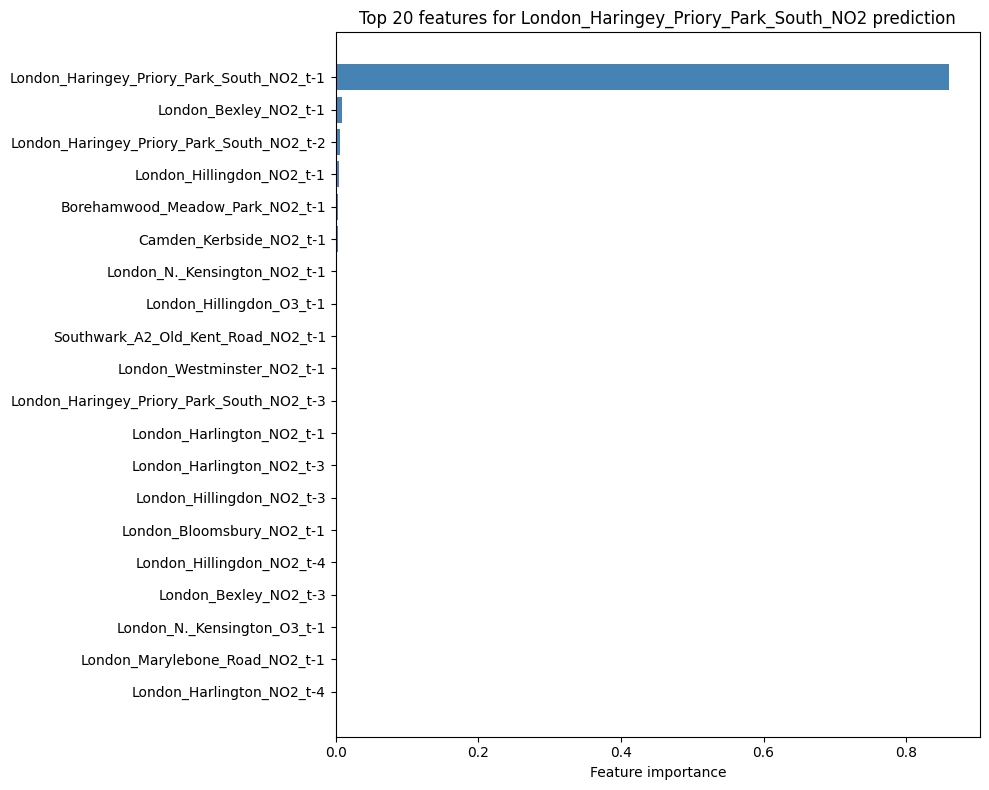


Figure saved to: /Users/burdzhuchaglayan/Desktop/data science projects/air-pollution-levels/data/defra/rf_model/feature_importance.png


In [18]:
# visualise top 20 features
fig, ax = plt.subplots(figsize=(10, 8))

top_20 = importance_df.head(20)
y_pos = range(len(top_20))

ax.barh(y_pos, top_20['importance'], color='steelblue')
ax.set_yticks(y_pos)
ax.set_yticklabels(top_20['feature'])
ax.invert_yaxis()  # highest at top
ax.set_xlabel('Feature importance')
ax.set_title(f'Top 20 features for {target_name} prediction')

plt.tight_layout()
plt.savefig(rf_output_dir / 'feature_importance.png', dpi=150, bbox_inches='tight')
plt.show()

print(f"\nFigure saved to: {rf_output_dir / 'feature_importance.png'}")

In [19]:
# analyse importance by category
print("Feature importance by category:")
print("-" * 40)

def categorise_feature(name):
    if 'hour' in name.lower():
        return 'temporal_hour'
    elif 'day' in name.lower():
        return 'temporal_day'
    elif 'month' in name.lower():
        return 'temporal_month'
    elif 'weekend' in name.lower():
        return 'temporal_weekend'
    elif 'NO2' in name:
        return 'NO2'
    elif 'PM10' in name:
        return 'PM10'
    elif 'O3' in name:
        return 'O3'
    else:
        return 'other'

importance_df['category'] = importance_df['feature'].apply(categorise_feature)

category_importance = importance_df.groupby('category')['importance'].sum().sort_values(ascending=False)

print(category_importance.to_string())
print(f"\nTotal importance: {category_importance.sum():.4f}")

Feature importance by category:
----------------------------------------
category
NO2                 0.956071
O3                  0.020879
PM10                0.015782
temporal_hour       0.005787
temporal_day        0.000864
temporal_month      0.000532
temporal_weekend    0.000085

Total importance: 1.0000


    Feature importance by category:
    ----------------------------------------
    category
    NO2                 0.956071
    O3                  0.020879
    PM10                0.015782
    temporal_hour       0.005787
    temporal_day        0.000864
    temporal_month      0.000532
    temporal_weekend    0.000085

    Total importance: 1.0000

### What the feature importance tells us

The analysis shows which inputs drive London_Haringey_Priory_Park_South_NO2 predictions:

**Target station selection note:** London Haringey Priory Park South was selected as DEFRA's target because it is the closest station to LAQN's EN5 (Enfield - Bowes Primary School), located only ~3.3 km apart. This enables direct comparison of model behaviour between the two monitoring networks.

**1. Same-station history dominates (London_Haringey_Priory_Park_South_NO2_t-1 = 86.1%)**

The previous hour's NO2 value at Haringey is by far the strongest predictor. This is strong temporal autocorrelation. NO2 levels change gradually, so the best predictor of next hour is the current hour.

Compared to LAQN's EN5 (83.5%), DEFRA's target station shows even stronger t-1 dominance (+2.6%). With fewer total stations in DEFRA (18 vs 78), importance concentrates more heavily on the target station's own history.

**2. Other NO2 stations contribute weakly (total NO2 = 95.6%)**

London_Bexley_NO2_t-1 (0.9%), London_Hillingdon_NO2_t-1 (0.5%), Borehamwood_Meadow_Park_NO2_t-1 (0.4%) etc. show weak spatial correlation. Nearby stations help slightly but not much.

**3. Cross-pollutant relationships are minimal**

| Pollutant | Importance |
| --- | --- |
| O3 | 2.1% |
| PM10 | 1.6% |

The pollutants are relatively independent. Knowing O3 or PM10 levels does not help much for predicting NO2. Note: DEFRA shows slightly stronger O3 relationship than LAQN (2.1% vs 1.2%).

**4. Temporal features (0.7% combined)**

| Feature | Importance |
| --- | --- |
| Hour of day | 0.58% |
| Day of week | 0.09% |
| Month | 0.05% |
| Weekend | 0.01% |

When pollution history is available, time features add little value. The model relies on autocorrelation rather than learning rush hour patterns directly. Like the same LAQN.

**Interpretation for research:**

The model learns: next hour NO2 ≈ current hour NO2 + small adjustments. This is realistic but also limiting. The model struggles to predict sudden changes or pollution spikes that differ from recent history.

Despite EN5 (LAQN) and Haringey (DEFRA) being only 3.3 km apart in North London, both models show the same fundamental behaviour: heavy reliance on t-1 autocorrelation (~83-86%) with minimal contribution from spatial neighbours, cross-pollutants, or temporal features. This suggests the persistence-based prediction pattern is a characteristic of NO2 behaviour in London, not an artefact of the monitoring network.

**DEFRA vs LAQN comparison:**

| Aspect | LAQN (EN5) | DEFRA (Haringey) |
| --- | --- | --- |
| Target station t-1 | 83.5% | 86.1% |
| Total NO2 | 95.7% | 95.6% |
| O3 importance | 1.2% | 2.1% |
| PM10 importance | 2.4% | 1.6% |
| Temporal combined | 0.8% | 0.7% |

DEFRA's higher concentration on t-1 (86% vs 83%) and stronger O3 relationship may contribute to its superior test performance (R² 0.855 vs 0.814).

## 9) Prediction visualisation

Plotting actual vs predicted values helps identify systematic errors or patterns the model misses.

**Scatter plot interpretation:**
- Points close to the red line = good predictions
- Spread around the line shows prediction variance
- If points curve away at high values, model underestimates pollution spikes

**Time series interpretation:**
- Actual and predicted lines should follow similar patterns
- Gaps between lines show prediction errors
- Consistent lag suggests model needs more recent history